In [1]:
import os
os.chdir('/home/yash/Desktop/tensorflow-adversarial/tf_example')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn import ModeKeys, Estimator
import _pickle as pickle
from scipy.misc import imread
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from fgsm_cifar import fgsm
from fgsm_cifar_wrt_class import fgsm_wrt_class
import mnist
import sys  
import matplotlib.patches as mpatches

img_rows = 32
img_cols = 32
img_chas = 3
input_shape = (img_rows, img_cols, img_chas)
n_classes = 10

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f,encoding='latin1')
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def find_l2(X_test, X_adv):
    a=X_test.reshape(-1,32*32*3)
    b=X_adv.reshape(-1,32*32*3)
    l2_unsquared = np.sum(np.square(a-b),axis=1)
    return l2_unsquared

def find_l2_batch(X_test, X_adv):
    ans = np.zeros([X_test.shape[0],n_classes], dtype = np.float32)
    for i in range(X_test.shape[0]):
        for j in range(n_classes):
            ans[i][j] = find_l2(X_test[i], X_adv[i][j])
    return ans


# m2 is the grouped flipping
# m1 is the single flipping
#This method returns the distance of each predictions from repective test points calculated by m1 and m2 resp. 
def find_m1_m2(X_test,X_adv_one,X_adv_test):
    dist_adv_m1 = find_l2(X_test, X_adv_one)
    b = find_l2_batch(X_test, X_adv_test)
    dist_adv_m2 = np.partition(b,axis=1,kth=1)[:,1]
    return np.sqrt(dist_adv_m1), np.sqrt(dist_adv_m2)

# Give this function X_adv_test it gives you the points corresponding to
# each example having min dists and their indices 


def give_m2_ans(X_test, X_adv_test,cls= -1):
    if(cls == -1):
        dists = find_l2_batch(X_test, X_adv_test)
        second_min_indices = np.partition(dists, axis=1, kth=1)[:,1]
        for i in range(X_test.shape[0]):
            second_min_indices[i] = (np.where(second_min_indices[i] == dists[i])[0][0])
        ans = np.empty([X_adv_test.shape[0], img_rows, img_cols, img_chas])
        for i in range(ans.shape[0]):
            ans[i] = X_adv_test[i][second_min_indices[i].astype(int)]
        return second_min_indices, ans
    else:
        return 0, get_flipped_class(X_adv_test,cls)

def remove_zeroes(X):
    indices = np.where(X == 0)[0]
    return np.delete(X,indices)

def get_class(X,Y,cls):
    Y=np.argmax(Y, axis=1)
    indices = np.where(Y==cls)
    return X[indices], Y[indices]

def make_label(i,m,e,n,r):
    if(r == False):
        return i + "_m" + str(m) + "_e" + str(e) + "_n" + str(n)
    else:
        base = i + "_m" + str(m) + "_e" + str(e) + "_n" + str(n) + "_r"
        lrn = base + "normal"
        return base, lrn

def get_flipped_class(X_adv,cls):
    return X_adv[:,cls]
    
def make_data(n):
    X_test_sub = X_test[:n]
    X_train_sub = X_train[:n]
    y_train_sub = sess.run(env.ybar, feed_dict={env.x: X_train_sub,env.training: False})
    y_train_sub = _to_categorical(np.argmax(y_train_sub, axis=1), n_classes)
    y_test_sub = sess.run(env.ybar, feed_dict={env.x:X_test_sub ,env.training: False})
    y_test_sub = _to_categorical(np.argmax(y_test_sub, axis=1), n_classes)
    
    return X_test_sub, y_test_sub, X_train_sub, y_train_sub

def get_flip_path(l):
    return 'data/cifar/' + l + '.npz'

def random_normal_func(X, n, save, lr, lrn):
    X=X.reshape(-1,img_rows*img_cols*img_chas)
    mean, std = np.mean(X, axis=0), np.std(X,axis=0)
    randomX = np.zeros([n,X[0].size])
    for i in range(X[0].size):
        randomX[:,i] = np.random.normal(mean[i],std[i],n)
    randomX = randomX.reshape(-1,img_rows,img_cols,img_chas)
    X_random_normal = randomX
    ans = sess.run(env.ybar, feed_dict={env.x: randomX,env.training: False})
    y_random_normal = _to_categorical(np.argmax(ans,axis=1), n_classes)
    X_random = np.random.rand(n,img_rows,img_cols,img_chas)
    y_random = sess.run(env.ybar, feed_dict={env.x: X_random,env.training: False})
    y_random = _to_categorical(np.argmax(y_random, axis=1), n_classes)
    
    if(save):
        np.savez(get_flip_path(lr), Xr=X_random)
        np.savez(get_flip_path(lrn), Xrn=X_random_normal)
    
    return X_random, y_random, X_random_normal, y_random_normal  

def run_flip(method, epochs, n, cls=-1):
    test_label = make_label("test", method, epochs,n, False)
    train_label = make_label("train", method, epochs,n, False)
    random_label = make_label("random", method, epochs,n, False)
    random_normal_label = make_label("random_normal", method, epochs,n, False)
    data_label_random, data_label_random_normal = make_label("_", method, epochs,n, True)
    
    X_test_sub, y_test_sub, X_train_sub, y_train_sub = make_data(n)
    X_random, y_random, X_random_normal, y_random_normal = random_normal_func(X_train,n, True, 
                                                                              data_label_random, data_label_random_normal)
    if(cls < -2 or cls > 9):
        print("Invalid Params")
        return
    
    
    if(method==1):
        X_flip_test = create_adv(X_test_sub, y_test_sub, test_label)
        X_flip_train = create_adv(X_train_sub, y_train_sub, train_label)
        X_flip_random = create_adv(X_random, y_random, random_label)
        X_flip_random_normal = create_adv(X_random_normal, y_random_normal, random_normal_label)
    
    if(method==2):
        X_flip_per_class_test = create_adv_wrt_class(X_test_sub, y_test_sub, test_label)
        X_flip_per_class_train = create_adv_wrt_class(X_train_sub, y_train_sub, train_label)
        X_flip_per_class_random = create_adv_wrt_class(X_random, y_random, random_label)
        X_flip_per_class_random_normal = create_adv_wrt_class(X_random_normal, y_random_normal, random_normal_label)
        
        _, X_flip_test = give_m2_ans(X_test_sub, X_flip_per_class_test, cls)
        _, X_flip_train = give_m2_ans(X_train_sub, X_flip_per_class_train, cls)
        _, X_flip_random = give_m2_ans(X_random,X_flip_per_class_random, cls)
        _, X_flip_random_normal = give_m2_ans(X_random_normal, X_flip_per_class_random_normal,cls)
    
#     a = _predict(X_flip_test, env)
#     print(np.argmax(a,axis=1))
    
    l2_test = find_l2(X_flip_test,X_test_sub)
    l2_train = find_l2(X_flip_train, X_train_sub)
    l2_random = find_l2(X_flip_random,X_random)
    l2_random_normal = find_l2(X_flip_random_normal,X_random_normal)

    return l2_test, l2_train, l2_random, l2_random_normal


def restore_random_data(lr, lrn):
    Xr = np.load(get_flip_path(lr))['Xr']
    Xrn = np.load(get_flip_path(lrn))['Xrn']
    y_random_normal = sess.run(env.ybar, feed_dict={env.x: Xrn,env.training: False})
    y_random_normal = _to_categorical(np.argmax(y_random_normal,axis=1), n_classes)
    y_random = sess.run(env.ybar, feed_dict={env.x: Xr,env.training: False})
    y_random = _to_categorical(np.argmax(y_random, axis=1), n_classes)
    
    return Xr, y_random, Xrn, y_random_normal


def restore_flip(method, epochs, n):
    test_label = make_label("test", method, epochs,n, False)
    train_label = make_label("train", method, epochs,n, False)
    random_label = make_label("random", method, epochs,n, False)
    random_normal_label = make_label("random_normal", method, epochs,n, False)
    data_label_random, data_label_random_normal = make_label("_", method, epochs,n, True)
    
    X_test_sub, y_test_sub, X_train_sub, y_train_sub = make_data(n)
    X_random, y_random, X_random_normal, y_random_normal = restore_random_data(data_label_random, data_label_random_normal)
    
    if(method==1):
        X_flip_test =  np.load(get_flip_path(test_label))['X_adv']
        X_flip_train = np.load(get_flip_path(train_label))['X_adv']
        X_flip_random = np.load(get_flip_path(random_label))['X_adv']
        X_flip_random_normal = np.load(get_flip_path(random_normal_label))['X_adv']
    
    if(method==2):
        X_flip_per_class_test = np.load(get_flip_path(test_label))['X_adv']
        X_flip_per_class_train = np.load(get_flip_path(train_label))['X_adv']
        X_flip_per_class_random = np.load(get_flip_path(random_label))['X_adv']
        X_flip_per_class_random_normal = np.load(get_flip_path(random_normal_label))['X_adv']
        
        _, X_flip_test = give_m2_ans(X_test_sub, X_flip_per_class_test )
        _, X_flip_train = give_m2_ans(X_train_sub, X_flip_per_class_train)
        _, X_flip_random = give_m2_ans(X_random,X_flip_per_class_random)
        _, X_flip_random_normal = give_m2_ans(X_random_normal, X_flip_per_class_random_normal)
    
    l2_test = find_l2(X_flip_test,X_test_sub)
    l2_train = find_l2(X_flip_train, X_train_sub)
    l2_random = find_l2(X_flip_random,X_random)
    l2_random_normal = find_l2(X_flip_random_normal,X_random_normal)

    return l2_test, l2_train, l2_random, l2_random_normal


def count_clear(l2_test, l2_train, l2_random, l2_random_normal):
    nz_test = np.count_nonzero(l2_test)
    nz_train = np.count_nonzero(l2_train)
    nz_random = np.count_nonzero(l2_random)
    nz_random_normal = np.count_nonzero(l2_random_normal)

    print ('\n test: ' + str(nz_test))
    print ('train: ' + str(nz_train))
    print ('random: ' + str(nz_random))
    print ('random normal: ' + str(nz_random_normal))

    l2_test = remove_zeroes(l2_test)
    l2_random = remove_zeroes(l2_random)
    l2_random_normal = remove_zeroes(l2_random_normal)
    l2_train = remove_zeroes(l2_train)

    min_no = min(nz_test, nz_train)
    l2_train = np.sqrt(l2_train[:min_no])
    l2_test = np.sqrt(l2_test[:min_no])
    l2_random = np.sqrt(l2_random[:min_no])
    l2_random_normal = np.sqrt(l2_random_normal[:min_no])

    return l2_test, l2_train, l2_random, l2_random_normal

def plot_data_graph(l2_test, l2_train, l2_random, l2_random_normal, n):
    %matplotlib inline
    t = np.arange(1,n+1, 1)
    plt.plot(t, l2_test[:n], 'r--', t, l2_train[:n],'b--', t, l2_random[:n], 'y--', l2_random_normal[:n], 'k--')
    blue_patch = mpatches.Patch(color='blue', label='Train Data')
    red_patch = mpatches.Patch(color='red', label='Test Data')
    yellow_patch = mpatches.Patch(color='yellow', label='Random Data')
    black_patch = mpatches.Patch(color='black', label='Random Normal Data')
    plt.legend(handles=[blue_patch, red_patch, yellow_patch, black_patch])
    
    plt.show()    

def plot_data_hist(l2,n,title):
    %matplotlib inline
    plt.hist(l2,n)
    plt.title(title)
    plt.xlabel("Distance")
    plt.ylabel("Frequency")
    
    plt.show()

In [2]:
print('\nLoading CIFAR10')
ab=sys.getdefaultencoding()
print(ab)
cifar10_dir = 'cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

X_train = X_train.reshape(-1, img_rows, img_cols, img_chas)
X_test = X_test.reshape(-1, img_rows, img_cols, img_chas)

# X_train=X_train[:100]
# y_train=y_train[:100]


Loading CIFAR10
utf-8


In [3]:
# one hot encoding, basically creates hte si
def _to_categorical(x, n_classes):
    x = np.array(x, dtype=int).ravel()
    n = x.shape[0]
    ret = np.zeros((n, n_classes))
    ret[np.arange(n), x] = 1
    return ret


y_train = _to_categorical(y_train, n_classes)
y_test = _to_categorical(y_test, n_classes)
print('\nShuffling training data')
ind = np.random.permutation(X_train.shape[0])
X_train, y_train = X_train[ind], y_train[ind]

# split training/validation dataset
validation_split = 0.1
n_train = int(X_train.shape[0]*(1-validation_split))
X_valid = X_train[n_train:]
X_train = X_train[:n_train]
y_valid = y_train[n_train:]
y_train = y_train[:n_train]

class Dummy:
    pass
env = Dummy()



Shuffling training data


In [4]:
print (X_test.shape)

(10000, 32, 32, 3)


In [5]:
def model(x, logits=False, training=False):
    conv0 = tf.layers.conv2d(x, filters=32, kernel_size=[3, 3],
                             padding='same', name='conv0',
                             activation=tf.nn.relu)
    
    pool0 = tf.layers.max_pooling2d(conv0, pool_size=[2, 2],
                                    strides=2, name='pool0')
    
    conv1 = tf.layers.conv2d(pool0, filters=64,
                             kernel_size=[3, 3], padding='same',
                             name='conv1', activation=tf.nn.relu)
   
 
    
    pool1 = tf.layers.max_pooling2d(conv1, pool_size=[2, 2],
                                    strides=2, name='pool1')
    
    conv2 = tf.layers.conv2d(pool1, filters=128,
                             kernel_size=[1,1], padding='same',
                             name='conv2', activation=tf.nn.relu)
    

    
    flat = tf.reshape(conv2, [-1, 8*8*128], name='flatten')
    
    dense1 = tf.layers.dense(flat, units= 1024, activation=tf.nn.relu,
                            name='dense1')
    
    dense2 = tf.layers.dense(dense1, units=128, activation=tf.nn.relu,
                            name='dense2')
    logits_ = tf.layers.dense(dense2, units=10, name='logits') #removed dropout
    
    y = tf.nn.softmax(logits_, name='ybar')
    
    if logits:
        return y, logits_
    return y


In [6]:
# We need a scope since the inference graph will be reused later
with tf.variable_scope('model'):
    env.x = tf.placeholder(tf.float32, (None, img_rows, img_cols,
                                        img_chas), name='x')
    env.y = tf.placeholder(tf.float32, (None, n_classes), name='y')
    env.training = tf.placeholder(bool, (), name='mode')

    env.ybar, logits = model(env.x, logits=True,
                             training=env.training)

    z = tf.argmax(env.y, axis=1)
    zbar = tf.argmax(env.ybar, axis=1)
    env.count = tf.cast(tf.equal(z, zbar), tf.float32)
    env.acc = tf.reduce_mean(env.count, name='acc')

    xent = tf.nn.softmax_cross_entropy_with_logits(labels=env.y,
                                                   logits=logits)
    env.loss = tf.reduce_mean(xent, name='loss')

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(extra_update_ops):
    env.optim = tf.train.AdamOptimizer(beta1=0.9, beta2=0.999, epsilon=1e-08,).minimize(env.loss) 


In [7]:
with tf.variable_scope('model', reuse=True):
    for i in range(n_classes):
        if(i==0):
            env.x_adv_wrt_class = (fgsm_wrt_class(model, env.x, i, step_size=.05, bbox_semi_side=10))
        else:
            x = (fgsm_wrt_class(model, env.x, i, step_size=.05, bbox_semi_side=10))
            env.x_adv_wrt_class = tf.concat([env.x_adv_wrt_class, x],axis=0)
    env.x_adv, env.all_flipped = fgsm(model, env.x, step_size=.05, bbox_semi_side=10) #epochs is redundant now!
    

In [8]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

In [9]:
def save_model(label):
    saver = tf.train.Saver()
    saver.save(sess,  './models/cifar/' + label)
    
def restore_model(label):
    saver = tf.train.Saver()
    saver.restore(sess, './models/cifar/' + label)

In [10]:
def _evaluate(X_data, y_data, env):
    print('\nEvaluating')
    n_sample = X_data.shape[0]
    batch_size = 128
    n_batch = int(np.ceil(n_sample/batch_size))
    loss, acc = 0, 0
    ns = 0
    for ind in range(n_batch):
        print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
        start = ind*batch_size
        end = min(n_sample, start+batch_size)
        batch_loss, batch_count, batch_acc = sess.run(
            [env.loss, env.count, env.acc],
            feed_dict={env.x: X_data[start:end],
                       env.y: y_data[start:end],
                       env.training: False})
        loss += batch_loss*batch_size
        print('batch count: {0}'.format(np.sum(batch_count)))
        ns+=batch_size
        acc += batch_acc*batch_size
    loss /= ns
    acc /= ns
#     print (ns)
#     print (n_sample)
    print(' loss: {0:.4f} acc: {1:.4f}'.format(loss, acc))
    return loss, acc

In [11]:
def _predict(X_data, env):
    print('\nPredicting')
    n_sample = X_data.shape[0]
    batch_size = 128
    n_batch = int(np.ceil(n_sample/batch_size))
    yval = np.empty((X_data.shape[0], n_classes))
    for ind in range(n_batch):
        print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
        start = ind*batch_size
        end = min(n_sample, start+batch_size)
        batch_y = sess.run(env.ybar, feed_dict={
            env.x: X_data[start:end], env.training: False})
        yval[start:end] = batch_y
    return yval

def train(label):
    print('\nTraining')
    n_sample = X_train.shape[0]
    batch_size = 128
    n_batch = int(np.ceil(n_sample/batch_size))
    n_epoch = 50
    for epoch in range(n_epoch):
        print('Epoch {0}/{1}'.format(epoch+1, n_epoch))
        for ind in range(n_batch):
            print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
            start = ind*batch_size
            end = min(n_sample, start+batch_size)
            sess.run(env.optim, feed_dict={env.x: X_train[start:end],
                                           env.y: y_train[start:end],
                                           env.training: True})
        if(epoch%5 == 0):
            model_label = label+ '{0}'.format(epoch)
            print("saving model " + model_label)
            save_model(model_label)
            
    save_model(label)
    

In [12]:
def create_adv_wrt_class(X, Y, label):
    print('\nCrafting adversarial')
    n_sample = X.shape[0]
    pred = np.argmax(Y,axis=1)
    batch_size = 1
    n_batch = int(np.ceil(n_sample/batch_size))
    n_epoch = 20
    x_adv_shape = list(X.shape)[1:]
    x_adv_shape = np.append(np.append(n_sample,n_classes),x_adv_shape)
    X_adv = np.empty(x_adv_shape)
    for ind in range(n_batch):
        print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
        start = ind*batch_size
        end = min(n_sample, start+batch_size)
        tmp = sess.run(env.x_adv_wrt_class, feed_dict={env.x: X[start:end],
                                             env.y: Y[start:end],
                                             env.training: False})
        tmp[pred[start]] = X[start]
        X_adv[start:end] = tmp
    print('\nSaving adversarial')
    os.makedirs('data', exist_ok=True)
    np.savez(get_flip_path(label), X_adv = X_adv)
    return X_adv

In [13]:
def create_adv(X, Y, label):
    print('\nCrafting adversarial')
    n_sample = X.shape[0]
    batch_size = 1
    n_batch = int(np.ceil(n_sample/batch_size))
    n_epoch = 20
    X_adv = np.empty_like(X)
    for ind in range(n_batch):
        print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
        start = ind*batch_size
        end = min(n_sample, start+batch_size)
        tmp, all_flipped = sess.run([env.x_adv, env.all_flipped], feed_dict={env.x: X[start:end],
                                             env.y: Y[start:end],
                                             env.training: False})
        X_adv[start:end] = tmp
    print('\nSaving adversarial')
    os.makedirs('data', exist_ok=True)
    np.savez(get_flip_path(label), X_adv = X_adv)
    return X_adv

In [14]:
method = 2
n = 1000
epochs = 150
label="cifar_with_cnn"
cls = -1

# train(label)
restore_model(label + str(epochs))
# _evaluate(X_train, y_train, env)

l2_test, l2_train, l2_random, l2_random_normal = run_flip(method,epochs,n, cls)
# l2_test, l2_train, l2_random, l2_random_normal = restore_flip(method,epochs,n)

l2_test, l2_train, l2_random, l2_random_normal = count_clear(l2_test, l2_train, l2_random, l2_random_normal)

INFO:tensorflow:Restoring parameters from ./models/cifar/cifar_with_cnn150

Crafting adversarial
 batch 1000/1000
Saving adversarial

Crafting adversarial
 batch 1000/1000
Saving adversarial

Crafting adversarial
 batch 1000/1000
Saving adversarial

Crafting adversarial
 batch 1000/1000
Saving adversarial

 test: 1000
train: 1000
random: 1000
random normal: 1000


In [15]:
# plot_data_graph(l2_test, l2_train, l2_random, l2_random_normal, 1000)

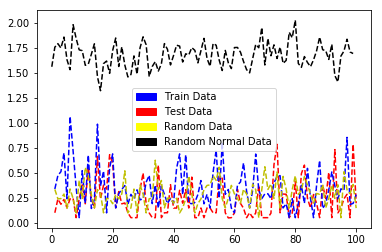

In [16]:
plot_data_graph(l2_test, l2_train, l2_random, l2_random_normal, 100)

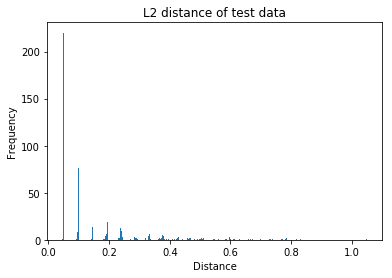

In [17]:
title = "L2 distance of test data"
plot_data_hist(l2_test,n,title)

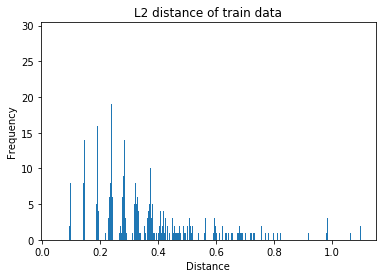

In [18]:
title = "L2 distance of train data"
plot_data_hist(l2_train,n,title)

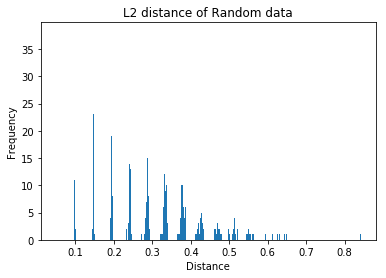

In [19]:
title = "L2 distance of Random data"
plot_data_hist(l2_random,n,title)

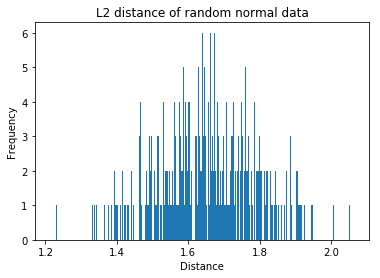

In [20]:
title = "L2 distance of random normal data"
plot_data_hist(l2_random_normal,n,title)

In [21]:
# a = np.load('data/cifar/' + test_m2 + '.npy')
# b = np.load('data/cifar/' + train_m2 + '.npy')
# c = np.load('data/cifar/' + random_m2 + '.npy')
# d = np.load('data/cifar/' + random_normal_m2 + '.npy')

# _, X_adv_test_m2 = give_m2_ans(X_test_sub, a )
# _, X_adv_train_m2 = give_m2_ans(X_train_sub, b )
# _, X_adv_random_m2 = give_m2_ans(X_random, c)
# _, X_adv_random_normal_m2 = give_m2_ans(X_random_normal, d)

# a = np.load('data/cifar/' + test_m2 + '.npy')
# b = np.load('data/cifar/' + train_m2 + '.npy')
# c = np.load('data/cifar/' + random_m2 + '.npy')
# d = np.load('data/cifar/' + random_normal_m2 + '.npy')

# _, X_adv_test_m2 = give_m2_ans(X_test_sub, a )
# _, X_adv_train_m2 = give_m2_ans(X_train_sub, b )

# l2_test_m2 = find_l2(X_adv_test_m2,X_test_sub)
# l2_train_m2 = find_l2(X_adv_train_m2, X_train_sub)
# l2_random_m2 = find_l2(X_adv_random_m2,X_random)
# l2_random_normal_m2 = find_l2(X_adv_random_normal_m2,X_random_normal)



